In [1]:
import numpy as np
import matplotlib.pyplot as plt

## from Homework 1 we have the Hamiltonian matrix

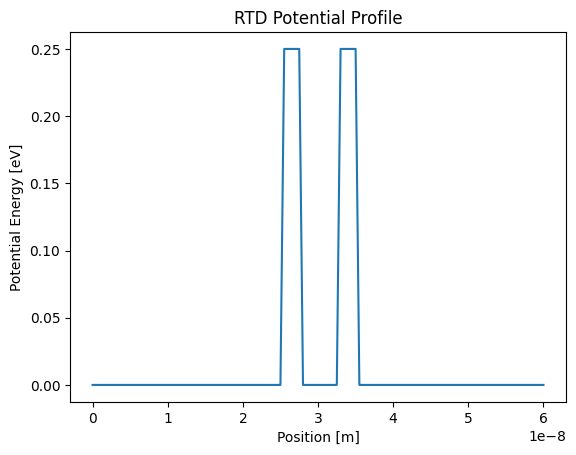

array([[ 4.88341146e-19, -2.44170573e-19,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.44170573e-19,  4.88341146e-19, -2.44170573e-19, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.44170573e-19,  4.88341146e-19, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.88341146e-19,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [2]:
from scipy.constants import hbar, m_e, eV, k, e
import numpy as np
from numpy import linalg

def Hamiltonian_create(m_eff, Lx, Nx, U):
    ax = Lx / (Nx - 1)
    Mx = Nx - 2  # Exclude boundaries

    tx = hbar**2 / (2 * m_eff * ax**2)

    # Hamiltonian matrix
    matrix = np.zeros((Nx, Nx))

    for i in range(Mx):
        matrix[i, i] = 2 * tx + U[i+1]  # Add potential at each point

        if i > 0:  # Left neighbor
            matrix[i, i - 1] = -tx
        if i < Mx - 1:  # Right neighbor
            matrix[i, i + 1] = -tx

    # Solve eigenvalue problem
    eigenvalues, eigenvectors = linalg.eigh(matrix)
    index = eigenvalues.argsort()
    eigenvalues = eigenvalues[index]
    eigenvectors = eigenvectors[:, index]

    return eigenvalues, eigenvectors, matrix

def wavefunction(eigenvectors, Nx, num_states):
    Mx = Nx - 2
    eigenstates = np.zeros((Mx, num_states))

    for k in range(num_states):
        for i in range(Mx):
            eigenstates[i, k] = eigenvectors[i, k]

    return eigenstates

import RTDpot
# Grid parameters
m_eff=0.1*m_e
NL = 121
L = 60e-9  # m
Vd = 0  # V
w = 2.5e-9  # m barrier width
h = 0.25  # V barrier height
d = 5e-9  # m barrier distance

# Get the potential and position data
x, U = RTDpot.RTDpot(Vd, L, NL, w, h, d)

# Convert position to nanometers

# Print or plot the result
import matplotlib.pyplot as plt

plt.plot(x, U)
plt.xlabel("Position [m]")
plt.ylabel("Potential Energy [eV]")
plt.title("RTD Potential Profile")
plt.show()

# Solve eigenvalue problem
eigenvalues, eigenvectors, matrix = Hamiltonian_create(m_eff, L, NL, U)

# Extract wavefunctions
num_states = 1
#U = wavefunction(eigenvectors, NL, num_states)
#U_sq = np.square(np.abs(U))  # Compute density

matrix

In [3]:
a=L/(NL-1)
t0 = hbar**2 / (2 * m_eff * a**2)
def get_k(eps):
    return np.arccos(1-eps/2/t0)/a

def get_SE_matrix(k, left_contact):
    SE=np.zeros((NL, NL), dtype=complex)
    if left_contact:
        SE[0, 0] = -t0*np.exp(1j*k*a)
    else:
        SE[NL-1, NL-1] = -t0*np.exp(1j*k*a)
    return SE

def Green_Function_calculation(U, E):
    #left contact
    temp=E-U[0] #If E − U < 0 (kinetic energy is negative), wave number -> imaginary
    if temp>0: #for positive kinetic energy we have a contact
        k1=get_k(temp)
        SE_matrix1=get_SE_matrix(k1, True)
    else: # for negative kinetic energy set the contact self-energy to zero
        SE_matrix1=np.zeros((NL, NL))

    #right contact, the same as for the left contact
    temp=E-U[-1]
    if temp>0:
        k1=get_k(temp)
        SE_matrix2=get_SE_matrix(k1, False)
    else:
        SE_matrix2=np.zeros((NL, NL))

    Hamiltonian_offdiagonal = -t0*np.ones((NL-1), dtype=float)
    Hamiltonian = np.diag(U+2*t0, k=0) + np.diag(Hamiltonian_offdiagonal, k=1) + np.diag(Hamiltonian_offdiagonal, k=-1)
    Green_Function_inverse = E*np.eye(NL) - Hamiltonian - SE_matrix1 - SE_matrix2
    Green_Function = np.linalg.inv(Green_Function_inverse)

    return Green_Function, SE_matrix1, SE_matrix2

In [4]:
E=0.1*eV
G_1, se1, se2=Green_Function_calculation(U, E)

## Transmission coefficient

$T(E) = \text{Tr}(\underline{\Gamma_1} \cdot \underline{A_1}) = \text{Tr}(\underline{\Gamma_1} \cdot \underline{G} \cdot \underline{\Gamma_2} \cdot \underline{G^\dagger}) = $
$= \text{Tr}(\underline{\Gamma_2} \cdot \underline{A_1}) = \text{Tr}(\underline{\Gamma_2} \cdot \underline{G} \cdot \underline{\Gamma_1} \cdot \underline{G^\dagger})$ 

Broadening matrix: $\Gamma = i \cdot (\underline{\Sigma} - \underline{\Sigma^\dagger})$

In [5]:
import numpy as np

def get_transmission(U, E):
    trans_coeff = []  

    for i, energy in enumerate(E):  
        (green, se1, se2) = Green_Function_calculation(U, energy)  
        green_adj = np.transpose(np.conjugate(G_1))
        # Broadening matrices
        Gamma1 = 1j * (se1 - np.transpose(np.conjugate(se1)))  
        Gamma2 = 1j * (se2 - np.transpose(np.conjugate(se2)))
        
        # Transmission coefficient calculation
        temp1=np.matmul(Gamma2, green_adj)
        temp2=np.matmul(green, temp1)
        temp3=np.matmul(Gamma1, temp2)
        trans_coeff.append(np.trace(temp3))  
        #print(np.trace(temp3))
    return np.array(trans_coeff)  # Return outside the loop

# define the constants and V=0
m_eff=0.1*m_e
NL = 121
L = 60e-9  # m
Vd = 0.0  # V
w = 2.5e-9  # m barrier width
h = 0.25  # V barrier height
d = 5e-9  # m barrier distance

# Get the potential and position data
x, U = RTDpot.RTDpot(Vd, L, NL, w, h, d)

# Define energies correctly
E = np.linspace(0, 0.8*eV, 700)  
T_E = get_transmission(U*eV, E)

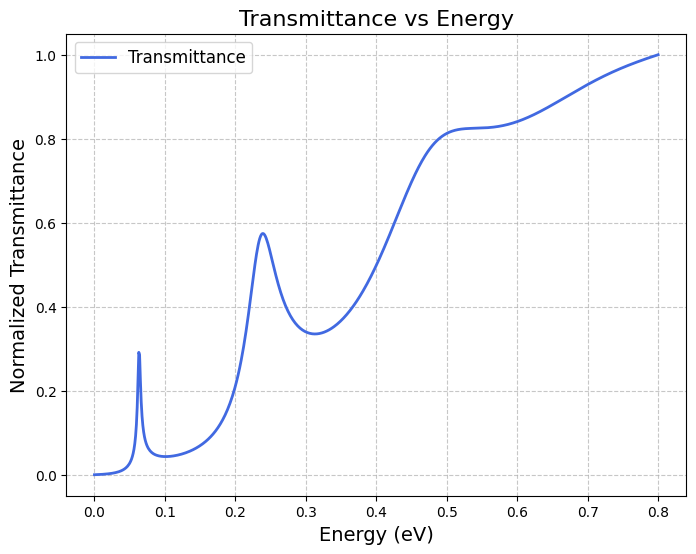

In [6]:
import matplotlib.pyplot as plt
import numpy as np

T_E_intensity = [abs(t) for t in T_E]  # Simplified intensity calculation
te_int = np.array(T_E_intensity)
te_max = te_int.max()

plt.figure(figsize=(8, 6))  # Set figure size for better visibility
plt.plot(E / eV, te_int / te_max, color="royalblue", linewidth=2, label="Transmittance")

# Customization
plt.xlabel("Energy (eV)", fontsize=14)
plt.ylabel("Normalized Transmittance", fontsize=14)
plt.title("Transmittance vs Energy", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)  # Dashed grid lines for a clean look
plt.savefig("Transmission.png", dpi=300)

plt.show()

## Current $I$

$I_1 = \frac{-2 e}{h} \int{\{f_1(E) - f_2(E)\} T(E) dE}$

In [ ]:
T=300 #K
voltage_points=50
voltages=np.linspace(0, 0.35, voltage_points)
current=np.zeros(voltage_points)
def dist_Fermi(E, mu):
    return 1/(1+np.exp((E-mu) / (k * T)))
for i in range(voltage_points):
    Vd=voltages[i]
    x, U = RTDpot.RTDpot(Vd, L, NL, w, h, d)
    T_E = get_transmission(U*eV, E)
    integrand=(dist_Fermi(E, (Vd+0.02)*eV) - dist_Fermi(E, 0.02*eV))*np.abs(T_E)
    current[i]=-2*e/(hbar*2*np.pi)*np.trapezoid(integrand, E)
plt.plot(voltages, abs(current))
data = np.column_stack((voltages, abs(current)))

# Save to CSV file
np.savetxt("data1.csv", data, delimiter=",", header="Voltages (V),Current (A)", comments="")

print("CSV file saved successfully!")

KeyboardInterrupt: 

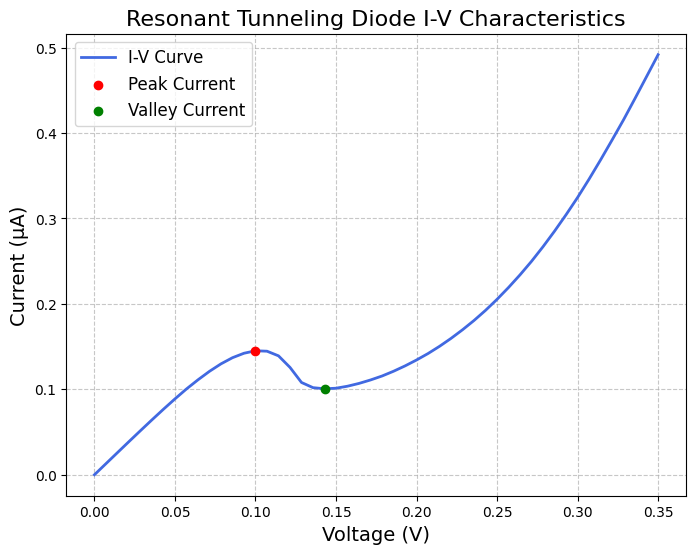

Peak Current Voltage: 0.100 V
Valley Current Voltage: 0.143 V


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
T=300 #K
def dist_Fermi(E, mu):
    return 1/(1+np.exp((E-mu) / (k * T)))
# Load data
df = pd.read_csv("data.csv")
voltage = df["Voltages (V)"]
current = df["Current (A)"] / te_max * 1e6  # Convert current to μA

# Find local maxima and minima
current_array = np.array(current)
voltage_array = np.array(voltage)

# Identify peak (local maximum before valley)
max_indices = argrelextrema(current_array, np.greater)[0]
peak_index = max_indices[0]  # First local maximum (before dip)
peak_voltage = voltage_array[peak_index]
peak_current = current_array[peak_index]

# Identify valley (local minimum after peak)
min_indices = argrelextrema(current_array, np.less)[0]
valley_index = min_indices[0]  # First local minimum (dip)
valley_voltage = voltage_array[valley_index]
valley_current = current_array[valley_index]

# Enhanced Plot
plt.figure(figsize=(8, 6))
plt.plot(voltage, current, label="I-V Curve", color="royalblue", linewidth=2)
plt.scatter(peak_voltage, peak_current, color="red", label="Peak Current", zorder=3)
plt.scatter(valley_voltage, valley_current, color="green", label="Valley Current", zorder=3)
plt.xlabel("Voltage (V)", fontsize=14)
plt.ylabel("Current (μA)", fontsize=14)
plt.title("Resonant Tunneling Diode I-V Characteristics", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("IV_characteristic.png", dpi=300)
plt.show()

print(f"Peak Current Voltage: {peak_voltage:.3f} V")
print(f"Valley Current Voltage: {valley_voltage:.3f} V")

## Density of states DOS

$A_{1, 2} = G \Gamma_{1, 2} G^\dagger$

In [8]:
def ldos_temp(green, gamma1, gamma2):
    A1=np.matmul(green, np.matmul(gamma1, np.transpose(np.conjugate(green))))
    A2=np.matmul(green, np.matmul(gamma2, np.transpose(np.conjugate(green))))
    return A1+A2

def get_ldos(U, E):
    (green, se1, se2) = Green_Function_calculation(U, E)
    Gamma1 = 1j * (se1 - np.transpose(np.conjugate(se1)))  
    Gamma2 = 1j * (se2 - np.transpose(np.conjugate(se2)))
    return np.diagonal(ldos_temp(green, Gamma1, Gamma2))
voltages=np.array([peak_voltage, valley_voltage]) #V

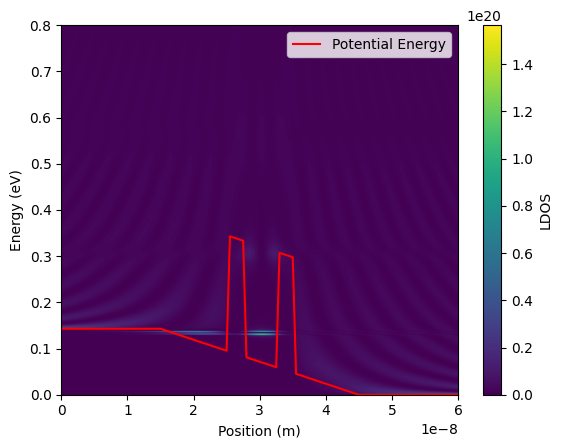

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Take only the first voltage
v = voltages[1]

# Compute potential
x, U = RTDpot.RTDpot(v, L, NL, w, h, d)

# Define energy values
E = np.linspace(0, 0.8 * eV, 700)
U = U * eV
result = []

# Compute LDOS for each energy
for energy in E:
    result.append(get_ldos(U, energy) / (2 * np.pi))

# Convert result to NumPy array
result = np.array(result)

# Plot LDOS heatmap using plt functions only
plt.imshow(
    np.real(result), extent=(0, L, 0, 0.8), origin="lower", cmap="viridis", aspect="auto"#, norm=mcolors.LogNorm()
)

# Add potential energy plot
plt.plot(x, U / eV, color="red", label="Potential Energy")

# Set labels and title
plt.xlabel("Position (m)")
plt.ylabel("Energy (eV)")
plt.legend()

# Add colorbar
plt.colorbar(label="LDOS")
plt.savefig("LDOS0143V.png", dpi=300)
# Show plot
plt.show()

In [10]:
def Gn(U, E):
    (green, se1, se2) = Green_Function_calculation(U, E)
    Gamma1 = 1j * (se1 - np.transpose(np.conjugate(se1)))  
    Gamma2 = 1j * (se2 - np.transpose(np.conjugate(se2)))
    A1=green @ Gamma1 @ np.transpose(np.conjugate(green))
    A2=green @ Gamma2 @ np.transpose(np.conjugate(green))
    return dist_Fermi(E, U[0]+0.02*eV)*A1 + dist_Fermi(E, U[-1]+0.02*eV)*A2

def calculate_densities(U, E):
    integrand=[]
    for Es in E:
        integrand.append(Gn(U, Es))
    integrand=np.array(integrand)
    result=np.trapezoid(integrand, E, axis=0)/(2*np.pi)
    return result

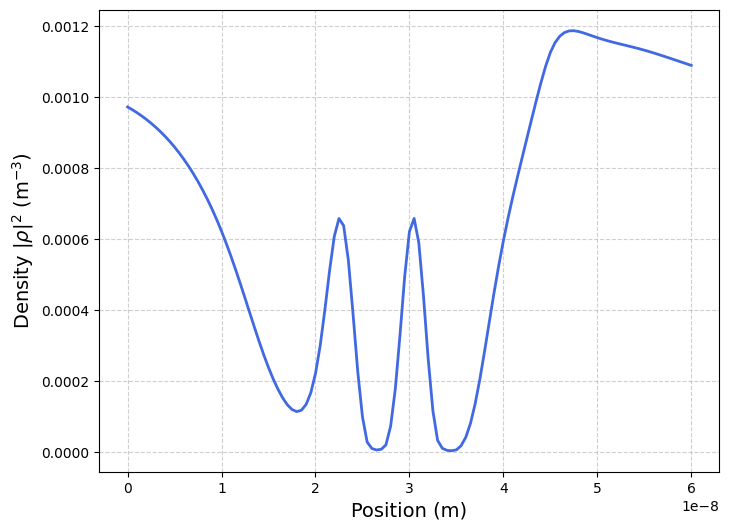

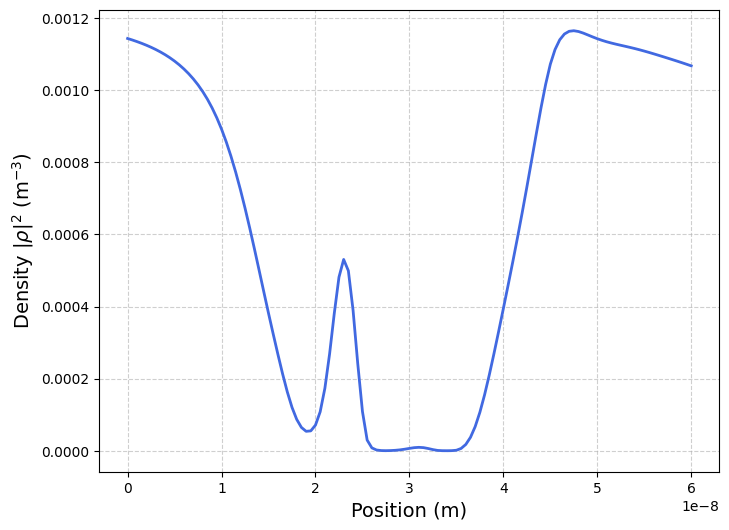

In [11]:
import matplotlib.pyplot as plt

for i, v in enumerate(voltages):
    x, U = RTDpot.RTDpot(v, L, NL, w, h, d)
    E = np.linspace(0, 0.8 * eV, 700)
    U = U * eV

    result = calculate_densities(U, E)

    plt.figure(figsize=(8, 6))  # Adjust figure size for better visibility
    plt.plot(x, np.square(np.abs(np.diagonal(result))), linewidth=2, color='royalblue')
    plt.xlabel("Position (m)", fontsize=14)
    plt.ylabel(r"Density $|\rho|^2$ (m$^{-3}$)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)  # Add a subtle grid
    
    filename = f"density_{i+1}.png"  # Save figures as density_1, density_2, etc.
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

In [12]:
import math
from scipy import optimize
def eigenenergies_qw(V0=h, a=w):
    eigenE=[]
    R=math.sqrt(2*m_eff*V0)*a/hbar
    xi=np.linspace(0, R, 1000)
    plt.xlim(0, R)
    plt.ylim(0, R)
    function=-xi*1/(np.tan(xi))
    quart=np.sqrt(R**2-xi**2)
    plt.plot(xi, function)
    plt.plot(xi, quart)
    xi=np.linspace(0, 1.5, 1000)
    function2=xi*np.tan(xi)
    plt.plot(xi, function2)
    plt.grid()
    plt.xlabel(r"$\eta$")
    plt.ylabel(r"$\xi$")
    plt.savefig("equations.png", dpi=300)
    plt.show()

    xi=optimize.bisect(lambda xi: np.sqrt(R**2-xi**2) - xi * np.tan(xi), 0, np.pi/2, xtol=1e-8)
    eta_sq=R**2-xi**2
    eigenE.append(V0-V0*eta_sq/(R**2))
    xi2=optimize.bisect(lambda xi: np.sqrt(R**2-xi**2) + xi*1/(np.tan(xi)), np.pi/2, R, xtol=1e-8)
    eta2_sq=R**2-xi2**2
    eigenE.append(V0-V0*eta2_sq/(R**2))
    eigenE=np.array(eigenE)
    eigenE=eigenE/eV
    return eigenE

In [30]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.constants as const  # Importing constants module

def eigenenergies_qw(V0=h*eV, a=w):
    eigenE = []
    R = math.sqrt(2 * m_eff * V0) * a / const.hbar  # Using physical constants

    # Define xi and plot functions
    xi = np.linspace(0, R, 1000)
    plt.xlim(0, R)
    plt.ylim(0, R)
    function = -xi * 1 / np.tan(xi)
    quart = np.sqrt(R**2 - xi**2)

    plt.plot(xi, function, label=r"-$\xi \cot{\xi}$")
    plt.plot(xi, quart, label=r"$\sqrt{R^2 - \xi^2}$")

    xi = np.linspace(0, 1.5, 1000)
    function2 = xi * np.tan(xi)
    plt.plot(xi, function2, label=r"$\xi \tan{\xi}$")

    # Improve plot aesthetics
    plt.grid()
    plt.xlabel(r"$\eta$")
    plt.ylabel(r"$\xi$")
    plt.legend()
    plt.savefig("equations.png", dpi=300)
    plt.show()

    # Solve for eigenvalues using optimization
    xi = optimize.bisect(lambda xi: np.sqrt(R**2 - xi**2) - xi * np.tan(xi), 0, np.pi/2, xtol=1e-8)
    eta_sq = R**2 - xi**2
    eigenE.append(V0 - V0 * eta_sq / (R**2))

    xi2 = optimize.bisect(lambda xi: np.sqrt(R**2 - xi**2) + xi * 1 / np.tan(xi), np.pi/2, R, xtol=1e-8)
    eta2_sq = R**2 - xi2**2
    eigenE.append(V0 - V0 * eta2_sq / (R**2))

    eigenE = np.array(eigenE)
    eigenE = eigenE / const.eV  # Convert to electron volts

    return eigenE

C:\Users\andri\AppData\Local\Temp\ipykernel_19976\3237819833.py:15: RuntimeWarning: invalid value encountered in divide
  function = -xi * 1 / np.tan(xi)


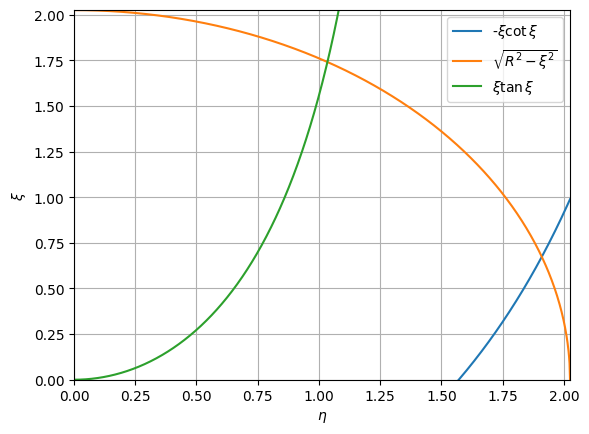

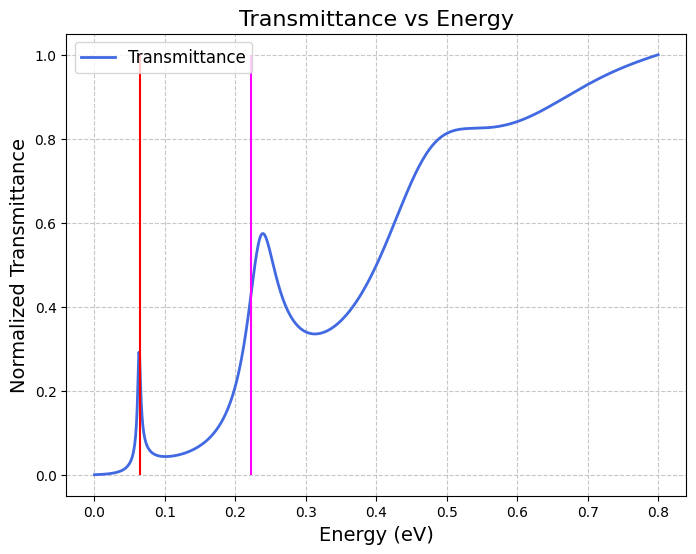

In [31]:
import numpy as np

def get_transmission(U, E):
    trans_coeff = []  

    for i, energy in enumerate(E):  
        (green, se1, se2) = Green_Function_calculation(U, energy)  
        green_adj = np.transpose(np.conjugate(G_1))
        # Broadening matrices
        Gamma1 = 1j * (se1 - np.transpose(np.conjugate(se1)))  
        Gamma2 = 1j * (se2 - np.transpose(np.conjugate(se2)))
        
        # Transmission coefficient calculation
        temp1=np.matmul(Gamma2, green_adj)
        temp2=np.matmul(green, temp1)
        temp3=np.matmul(Gamma1, temp2)
        trans_coeff.append(np.trace(temp3))  
        #print(np.trace(temp3))
    return np.array(trans_coeff)  # Return outside the loop

# define the constants and V=0
m_eff=0.1*m_e
NL = 121
L = 60e-9  # m
Vd = 0.0  # V
w = 2.5e-9  # m barrier width
h = 0.25  # V barrier height
d = 5e-9  # m barrier distance

# Get the potential and position data
x, U = RTDpot.RTDpot(Vd, L, NL, w, h, d)

# Define energies correctly
E = np.linspace(0, 0.8*eV, 700)  
T_E = get_transmission(U*eV, E)
import matplotlib.pyplot as plt
import numpy as np
eigenEnergies=eigenenergies_qw()
T_E_intensity = [abs(t) for t in T_E]  # Simplified intensity calculation
te_int = np.array(T_E_intensity)
te_max = te_int.max()

plt.figure(figsize=(8, 6))  # Set figure size for better visibility
plt.plot(E / eV, te_int / te_max, color="royalblue", linewidth=2, label="Transmittance")
plt.vlines(eigenEnergies, 0, 1, colors=["red", "magenta"])
# Customization
plt.xlabel("Energy (eV)", fontsize=14)
plt.ylabel("Normalized Transmittance", fontsize=14)
plt.title("Transmittance vs Energy", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)  # Dashed grid lines for a clean look
plt.savefig("Transmission_eigenE.png", dpi=300)

plt.show()